In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense_enc1 = nn.Linear(28*28, 256)
        self.dense_enc2 = nn.Linear(256, 64)
        self.dense_encmean = nn.Linear(64, 10)
        self.dense_encvar = nn.Linear(64, 10)
        self.dense_dec1 = nn.Linear(10, 64)
        self.dense_dec2 = nn.Linear(64, 256)
        self.dense_dec3 = nn.Linear(256, 28*28)
    
    def _encoder(self, x):
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        mean = self.dense_encmean(x)
        var = F.softplus(self.dense_encvar(x))
        return mean, var
    
    def _sample_z(self, mean, var):
        epsilon = torch.randn(mean.shape).to(device)
        return mean + torch.sqrt(var) * epsilon
    
    def decoder(self, z):
        x = F.relu(self.dense_dec1(z))
        x = F.relu(self.dense_dec2(x))
        x = torch.sigmoid(self.dense_dec3(x))
        return x
    
    def forward(self, x):
        mean, var = self._encoder(x)
        z = self._sample_z(mean, var)
        x = self.decoder(z)
        return x, z
    
    def loss(self, x):
        mean, var = self._encoder(x)
        z = self._sample_z(mean, var)
        y = self.decoder(z)
        reconstruction = -torch.mean(torch.sum(x * torch.log(y) + (1-x) * torch.log(1-y), dim=1))
        KL = -0.5 * torch.mean(torch.sum(1 + torch.log(var) - mean**2 - var, dim=1))
        return KL+reconstruction
    
    
    
batch_size = 256
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

mnist_train = MNIST("MNIST", train=True, download=True, transform=transform)
mnist_test = MNIST("MNIST", train=False, download=True, transform=transform)


train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

cpu


In [2]:
net = VAE()
net.to(device)

optimizer = optim.Adam(net.parameters(), lr=0.001)
epoch_num = 30
running_loss = np.zeros(epoch_num)

for epoch in range(epoch_num):
    for i, data in enumerate(train_loader, 0):
        inputs = data[0].to(device)
        optimizer.zero_grad() 
        outputs, _ = net(inputs)
        loss = net.loss(inputs) 
        loss.backward() 
        optimizer.step() 
        running_loss[epoch] += loss.item()       
        
    running_loss[epoch] /= len(train_loader)

    print("epoch : %d, train_loss : %.4lf" % (epoch, running_loss[epoch]))
    

epoch : 0, train_loss : 217.4068
epoch : 1, train_loss : 160.1800
epoch : 2, train_loss : 139.9152
epoch : 3, train_loss : 131.7150
epoch : 4, train_loss : 126.3479
epoch : 5, train_loss : 122.7245
epoch : 6, train_loss : 119.8556
epoch : 7, train_loss : 117.6945
epoch : 8, train_loss : 116.2324
epoch : 9, train_loss : 114.9628
epoch : 10, train_loss : 113.8897
epoch : 11, train_loss : 113.1146
epoch : 12, train_loss : 112.3513
epoch : 13, train_loss : 111.7138
epoch : 14, train_loss : 111.1394
epoch : 15, train_loss : 110.6948
epoch : 16, train_loss : 110.1669
epoch : 17, train_loss : 109.7799
epoch : 18, train_loss : 109.4158
epoch : 19, train_loss : 109.0948
epoch : 20, train_loss : 108.7564
epoch : 21, train_loss : 108.4978
epoch : 22, train_loss : 108.2405
epoch : 23, train_loss : 107.9954
epoch : 24, train_loss : 107.7562
epoch : 25, train_loss : 107.5937
epoch : 26, train_loss : 107.3873
epoch : 27, train_loss : 107.1534
epoch : 28, train_loss : 106.9523
epoch : 29, train_loss :

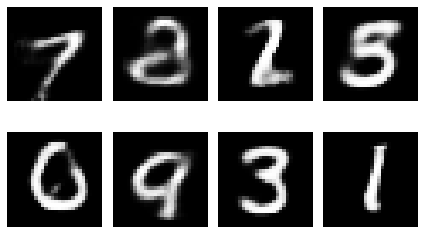

In [3]:
batch_size=8

z = torch.randn(batch_size, 10, device = device) 

images = net.decoder(z)
images = images.view(-1, 28, 28)
images = images.squeeze().detach().numpy()

for i, image in enumerate(images):
    plt.subplot(2, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()